# Image Classification of Australian Animals

William Li z5257749

The goal of the project is to create a model that can classify a selection of Australian animals. There are 8 animals:
- Cockatoo
- Dingo
- Kangaroo
- Koala
- Kookaburra
- Platypus
- Seadragon
- Wombat

The metric used to assess models is categorical accuracy.

## Import packages and set seed

In [1]:
%load_ext pycodestyle_magic

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import itertools
import pickle
import hiplot as hip

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.utils import load_img, img_to_array, set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Resizing
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
tf.keras.utils.set_random_seed(777)

## Data loading and preprocessing

Data is located in the "Data" folder, with images of each animal being in a different subfolder.

There are 200 images for each animal. The images were collected from Google Images with the help of the Image Downloader extension. They were selected manually to ensure accuracy and avoid duplicates (though the latter is not guaranteed as I can't perfectly recall 200 images)

In [3]:
labels = []
data_raw = []

folder_list = os.listdir('Data')
folder_list.sort()
for folder_name in folder_list:
    folder_path = os.path.join('Data', folder_name)
    
    # There are some system files that are not directories
    if not os.path.isdir(folder_path):
        continue
        
    file_list = os.listdir(folder_path)
    file_list.sort()
    for file_name in file_list:
        if file_name.endswith('.jpeg'):
            file_path = os.path.join(folder_path, file_name)
            img = load_img(file_path)
            img_array = img_to_array(img)
            #normalise inputs from [0, 255] to [0, 1]
            img_array /= 255
            
            data_raw.append(img_array)
            
            labels.append(folder_name)

In [4]:
labels = np.array(labels)

enc = OneHotEncoder(sparse=False)
labels_oh = enc.fit_transform(labels.reshape(-1,1))

train_test_split used 3 times to segment data into 4 sets. Their purpose and number of examples per class are:
- Training (96)
- Validation for early-stopping (32)
- Validation for hyperparameter tuning (32) and
- Test (40)

Validation set for early-stopping explicitly defined here rather than using validation_split in model.train as stratify is only available here.

In [5]:
X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(
    data_raw, labels_oh, test_size=0.2, shuffle=True, random_state=777, stratify=labels)

X_train_es_raw, X_val_raw, y_train_es, y_val = train_test_split(
    X_train_val_raw, y_train_val, test_size=0.2, shuffle=True, random_state=777, stratify=y_train_val)

X_train_raw, X_es_raw, y_train, y_es = train_test_split(
    X_train_es_raw, y_train_es, test_size=0.25, shuffle=True, random_state=777, stratify=y_train_es)

In [6]:
def list_to_resized_array(img_list):
    return np.array([tf.image.resize(img, (128, 128)) for img in img_list])

In [7]:
#Resize images
X_train = list_to_resized_array(X_train_raw)
X_es = list_to_resized_array(X_es_raw)
X_val = list_to_resized_array(X_val_raw)
X_test = list_to_resized_array(X_test_raw)

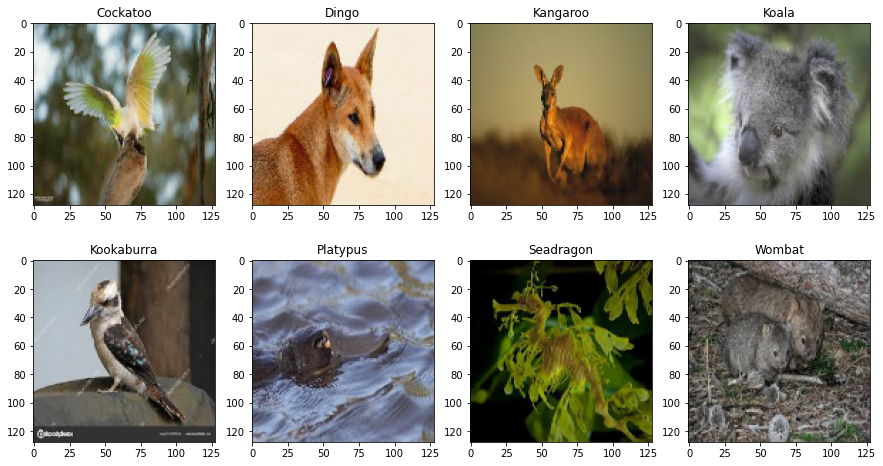

In [8]:
fig = plt.figure(figsize=(15,8))
for class_index in range(y_train.shape[1]):   
    plt.subplot(2, 4, class_index+1)
    image_index = np.where(y_train[:, class_index])[0][4]
    plt.imshow(X_train[image_index])
    plt.title(enc.categories_[0][class_index])
plt.show()

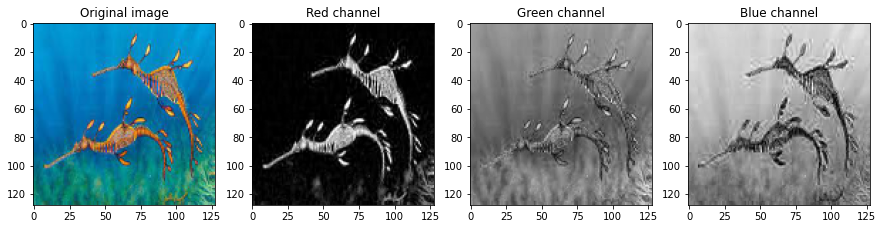

In [9]:
fig = plt.figure(figsize=(15, 5))
img_index=85

plt.subplot(1, 4, 1)
plt.imshow(X_train[img_index])
plt.title('Original image')

plt.subplot(1, 4, 2)
plt.imshow(X_train[img_index, :, :, 0], cmap='gray')
plt.title('Red channel')

plt.subplot(1, 4, 3)
plt.imshow(X_train[img_index, :, :, 1], cmap='gray')
plt.title('Green channel')

plt.subplot(1, 4, 4)
plt.imshow(X_train[img_index, :, :, 2], cmap='gray')
plt.title('Blue channel')

plt.savefig("colour_channels.jpg")
plt.show()

### Image augmentation
Image augmentation may be helpful for the training set, as we have a fairly small dataset.

In [10]:
def zoom_corner(img_list, position='random', proportion=0.8, random_state=777):
    set_random_seed(random_state)
    new_img_list = []
    rand = position == 'random'
    
    for img in img_list:
        height = img.shape[0]
        width = img.shape[1]
        new_height = round(height*proportion)
        new_width = round(width*proportion)
        
        if rand:
            position = random.choice(['top-left', 'top-right', 'bottom-left', 'bottom-right'])
        
        if position == 'top-left':
            new_img = img[:new_height, :new_width, :]
        elif position == 'top-right':
            new_img = img[:new_height, -new_width:, :]
        elif position == 'bottom-left':
            new_img = img[-new_height:, :new_width, :]
        elif position == 'bottom-right':
            new_img = img[-new_height:, -new_width:, :]
        else:
            raise Exception("Invalid position")
        
        new_img_list.append(new_img)
        
    new_img_array = list_to_resized_array(new_img_list)
    return new_img_array

In [11]:
def rotate(img_list, rotation_angle, zoom_factor=-0.25, random_state=777):
    set_random_seed(random_state)
    new_img_list = []
    rotation_factor = rotation_angle/360
    
    seq = Sequential([
        #setting both lower and upper bound equal means deterministic behaviour
        RandomRotation((-rotation_factor, rotation_factor), fill_mode='reflect'),
        #Zoom in as rotation causes corners to be outside the boundaries
        RandomZoom((zoom_factor, zoom_factor))
    ])
    
    for img in img_list:
        
        new_img = seq(img, training=True)
        new_img_list.append(new_img)
    
    new_img_array = list_to_resized_array(new_img_list)
    return new_img_array

In [12]:
X_train_random_corner = zoom_corner(X_train_raw, position='random', random_state=777)
X_train_rotate = rotate(X_train_raw, 12, random_state=777)

In [13]:
X_train_flip = X_train[:, :, ::-1, :]
X_train_random_corner_2 = zoom_corner(X_train_raw, position='random', random_state=778)
X_train_random_corner_flip = X_train_random_corner[:, :, ::-1, :]
X_train_rotate_2 = rotate(X_train_raw, 12, random_state=778)
X_train_rotate_flip = X_train_rotate[:, :, ::-1, :]

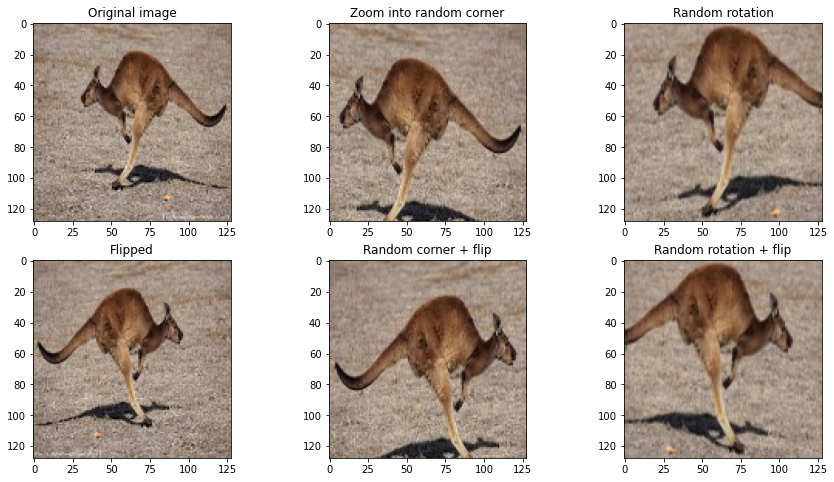

In [14]:
fig = plt.figure(figsize=(15, 8))
img_index = 0

plt.subplot(2, 3, 1)
plt.imshow(X_train[img_index])
plt.title('Original image')

plt.subplot(2, 3, 2)
plt.imshow(X_train_random_corner[img_index])
plt.title('Zoom into random corner')

plt.subplot(2, 3, 3)
plt.imshow(X_train_rotate[img_index])
plt.title('Random rotation')

plt.subplot(2, 3, 4)
plt.imshow(X_train_flip[img_index])
plt.title('Flipped')

plt.subplot(2, 3, 5)
plt.imshow(X_train_random_corner_flip[img_index])
plt.title('Random corner + flip')

plt.subplot(2, 3, 6)
plt.imshow(X_train_rotate_flip[img_index])
plt.title('Random rotation + flip')

plt.savefig('augment_demo.jpg')
plt.show()

In [15]:
X_train_variations = [X_train, X_train_random_corner, X_train_rotate,
                      X_train_flip, X_train_random_corner_flip, X_train_rotate_flip]
X_train_aug = np.concatenate(X_train_variations)
y_train_aug = np.concatenate([y_train]*len(X_train_variations))

In [16]:
### Shuffle after adding the modified images
set_random_seed(777)
perm = np.random.permutation(X_train_aug.shape[0])
X_train_aug = X_train_aug[perm]
y_train_aug = y_train_aug[perm]

## Benchmark model: Logistic regression

In [17]:
def resize_array(img_array, new_size):
    img_array_small = []
    for img in img_array:
        img_array_small.append(tf.image.resize(img, new_size))
    return np.array(img_array_small)

In [18]:
#Logistic regression doesn't need early stopping, so the data can be used for training
X_train_lr = np.concatenate((X_train_aug, X_es))
y_train_lr = np.concatenate((y_train_aug, y_es))

#128x128 RGB has too many features for logistic regression, so resize 8x8 so there are 8*8*3=192 features
X_train_lr_8 = resize_array(X_train_lr, (8, 8))
X_val_8 = resize_array(X_val, (8, 8))

X_train_lr_flat = X_train_lr_8.reshape(X_train_lr.shape[0], -1)
X_val_flat = X_val_8.reshape(X_val.shape[0], -1)
y_train_lr_1d = np.argmax(y_train_lr, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

num_classes = y_train_lr.shape[1]

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_lr_flat, y_train_lr_1d)
y_val_pred = lr_model.predict(X_val_flat)
np.mean(y_val_1d == y_val_pred)

0.4765625

Logistic regression gives an accuracy of 47.66% in validation set. It is not great but considerably higher than random guessing (which would give an accuracy of 12.5%).

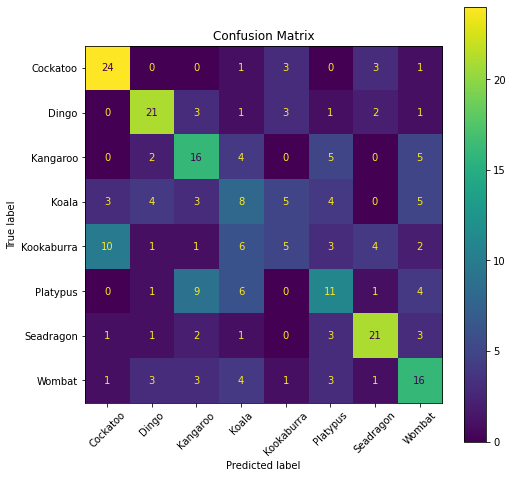

In [19]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_val_1d, y_val_pred, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig('lr_confusion.jpg', bbox_inches="tight")
plt.show()

In [20]:
coef = np.reshape(lr_model.coef_, (8, 64, 3))
np.mean(coef, axis=1)

array([[-0.18431569,  0.32069259, -0.02199028],
       [ 0.25566952, -0.13130189, -0.05435307],
       [ 0.2291178 , -0.02136869, -0.13323609],
       [ 0.01152088, -0.06156486,  0.0760106 ],
       [-0.13214048,  0.11666434,  0.01095564],
       [ 0.02556228, -0.14751905,  0.01135118],
       [-0.42252431,  0.25108053,  0.01132457],
       [ 0.21710998, -0.32668297,  0.09993744]])

These are the average coefficients of each colour channel across all 64 pixels. It could be possible to interpret some of these coefficients. For example, the coefficient of red is reasonably positive on average for dingo and kangaroo classes, which is likely due to both animals having a reddish colour, and inhabiting drier areas which may have more red color. 

## Simple neural network

In [21]:
set_random_seed(777)
model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 3)))
model.add(Resizing(16, 16))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
print(model.summary())

model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es=EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
hist=model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es), batch_size=128)

model.evaluate(X_val, y_val)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 16, 16, 3)         0         
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)              

2022-07-08 21:08:13.962445: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
36/36 [==============================] - 3s 44ms/step - loss: 2.2561 - categorical_accuracy: 0.2148 - val_loss: 1.8493 - val_categorical_accuracy: 0.2852
Epoch 2/100
36/36 [==============================] - 0s 11ms/step - loss: 1.8534 - categorical_accuracy: 0.2975 - val_loss: 1.7659 - val_categorical_accuracy: 0.3320
Epoch 3/100
36/36 [==============================] - 0s 12ms/step - loss: 1.7645 - categorical_accuracy: 0.3453 - val_loss: 1.7589 - val_categorical_accuracy: 0.3086
Epoch 4/100
36/36 [==============================] - 0s 11ms/step - loss: 1.7658 - categorical_accuracy: 0.3316 - val_loss: 1.7351 - val_categorical_accuracy: 0.3477
Epoch 5/100
36/36 [==============================] - 0s 11ms/step - loss: 1.7143 - categorical_accuracy: 0.3613 - val_loss: 1.6665 - val_categorical_accuracy: 0.3516
Epoch 6/100
36/36 [==============================] - 0s 13ms/step - loss: 1.6988 - categorical_accuracy: 0.3726 - val_loss: 1.5913 - val_categorical_accuracy: 0.3867
Epoc

[1.479097604751587, 0.46484375]

In [22]:
def define_simple_nn(resizing_size, neurons_1, neurons_2, neurons_3, dropout_rate, activation):
    model = Sequential()
    model.add(InputLayer(input_shape=(128, 128, 3)))
    model.add(Resizing(resizing_size, resizing_size))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_1, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_2, activation=activation))
    model.add(Dropout(dropout_rate))
    if neurons_3 is not None:
        model.add(Dense(neurons_3, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='softmax'))
    return model

In [25]:
def generate_param_combos(param_options):
    combo_lists = itertools.product(*param_options.values())
    combo_dicts = []
    for combo in combo_lists:
        combo_dicts.append(dict(zip(param_options.keys(), combo)))
    return combo_dicts

In [26]:
simple_nn_param_options = {
    'resizing_size':[8, 16, 32, 64],
    'neurons_1': [512, 1024],
    'neurons_2': [256, 512],
    'neurons_3': [None, 128, 256],
    'dropout_rate': [0, 0.2, 0.4],
    'activation': ['relu', 'tanh']
}

simple_nn_param_combos = generate_param_combos(simple_nn_param_options)
print(f"{len(simple_nn_param_combos)} parameter combinations")

288 parameter combinations


In [41]:
#Grid search code, takes 2 hours to run on my computer
"""
set_random_seed(777)
es = EarlyStopping(patience=20, restore_best_weights=True)
for param_combo in simple_nn_param_combos:
    print(param_combo)
    model = define_simple_nn(**param_combo)
    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),
              batch_size=128, verbose=0)
    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)
    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)
    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)
    
simple_nn_df = pd.DataFrame(simple_nn_param_combos)
simple_nn_df.to_csv('simple_nn_grid_search.csv', index=False)
"""

"\nset_random_seed(777)\nes = EarlyStopping(patience=20, restore_best_weights=True)\nfor param_combo in simple_nn_param_combos:\n    print(param_combo)\n    model = define_simple_nn(**param_combo)\n    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])\n    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),\n              batch_size=128, verbose=0)\n    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)\n    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)\n    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)\n    \nsimple_nn_df = pd.DataFrame(simple_nn_param_combos)\nsimple_nn_df.to_csv('simple_nn_grid_search.csv', index=False)\n"

In [28]:
simple_nn_df = pd.read_csv('simple_nn_grid_search.csv')
exp = hip.Experiment.from_dataframe(simple_nn_df)
exp.display_data(hip.Displays.PARALLEL_PLOT).update(
    {'hide': ['train_loss', 'train_acc', 'es_loss', 'es_acc']})
exp.display();

<IPython.core.display.Javascript object>

In [58]:
simple_nn_df.sort_values('val_acc', ascending=False)

,resizing_size,neurons_1,neurons_2,neurons_3,dropout_rate,activation,train_loss,train_acc,es_loss,es_acc,val_loss,val_acc
137,16,1024,512,128.0,0.4,tanh,1.082267,0.635417,1.476330,0.457031,1.458636,0.484375
0,8,512,256,NaN,0.0,relu,0.742182,0.770833,1.419623,0.468750,1.505148,0.480469
127,16,1024,512,NaN,0.0,tanh,0.878368,0.712240,1.549725,0.464844,1.559565,0.476562
110,16,1024,256,NaN,0.2,relu,1.029170,0.687500,1.432843,0.468750,1.497972,0.476562
101,16,512,512,128.0,0.4,tanh,1.130765,0.626302,1.461168,0.480469,1.488104,0.476562
...,...,...,...,...,...,...,...,...,...,...,...,...
283,64,1024,512,256.0,0.0,tanh,1.670465,0.342448,1.772545,0.296875,1.773517,0.273438
287,64,1024,512,256.0,0.4,tanh,1.663480,0.325521,1.771984,0.296875,1.782797,0.269531
251,64,512,512,256.0,0.4,tanh,1.676870,0.315104,1.767386,0.257812,1.795978,0.265625
263,64,1024,256,128.0,0.4,tanh,1.700344,0.316406,1.769099,0.296875,1.796087,0.257812


The best set of parameters resulted in an accuracy of 48.44%, slightly higher than logistic regression. However, it is quite likely that simple neural network is actually inferior to logistic regression as only 2 of the 288 parameter combinations outperformed it, which could easily be due to random variance.

## Convolutional neural network

In [59]:
set_random_seed(777)
model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 3)))
model.add(Conv2D(64, 7, 4, padding='same', activation='tanh'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, 3, 1, padding='same', activation='tanh'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, 3, 1, padding='same', activation='tanh'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
print(model.summary())

model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es=EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es), batch_size=128)

preds=model.predict(X_val)
model.evaluate(X_val, y_val)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 256)       

[0.9790791869163513, 0.67578125]

In [79]:
def define_cnn(filter_size_1, filter_size_2, pooling, dropout_rate, activation):
    Pooling2D = MaxPooling2D if pooling == 'max' else AveragePooling2D
    model = Sequential()
    model.add(InputLayer(input_shape=(128, 128, 3)))
    model.add(Conv2D(64, filter_size_1, 4, padding='same', activation=activation))
    model.add(Pooling2D(2, 2))
    model.add(Conv2D(128, filter_size_2, 1, padding='same', activation=activation))
    model.add(Pooling2D(2, 2))
    model.add(Conv2D(256, 3, 1, padding='same', activation=activation))
    model.add(Pooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='softmax'))
    return model

In [80]:
cnn_param_options = {
    'filter_size_1': [5, 7, 9, 11],
    'filter_size_2': [3, 5],
    'pooling': ['average', 'max'],
    'dropout_rate': [0, 0.2, 0.4],
    'activation': ['relu', 'tanh']
}

cnn_param_combos = generate_param_combos(cnn_param_options)
print(f"{len(cnn_param_combos)} parameter combinations")

96 parameter combinations


In [82]:
set_random_seed(777)
es = EarlyStopping(patience=20, restore_best_weights=True)
for param_combo in cnn_param_combos:
    print(param_combo)
    model = define_cnn(**param_combo)
    model.compile(tf.keras.optimizers.Adam(0.0005), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),
              batch_size=128, verbose=1)
    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)
    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)
    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)
    
cnn_df = pd.DataFrame(cnn_param_combos)
cnn_df.to_csv('cnn_grid_search.csv', index=False)

{'filter_size_1': 5, 'filter_size_2': 3, 'pooling': 'average', 'dropout_rate': 0, 'activation': 'relu'}
Epoch 1/100
36/36 [==============================] - 6s 160ms/step - loss: 1.9101 - categorical_accuracy: 0.2485 - val_loss: 1.8039 - val_categorical_accuracy: 0.3398
Epoch 2/100
36/36 [==============================] - 6s 166ms/step - loss: 1.7060 - categorical_accuracy: 0.3448 - val_loss: 1.7054 - val_categorical_accuracy: 0.3594
Epoch 3/100
36/36 [==============================] - 5s 139ms/step - loss: 1.5800 - categorical_accuracy: 0.4054 - val_loss: 1.6079 - val_categorical_accuracy: 0.4453
Epoch 4/100
12/36 [=========>....................] - ETA: 3s - loss: 1.5556 - categorical_accuracy: 0.4134

KeyboardInterrupt: 

## Visualise filters and feature maps

Method from https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn

In [68]:
image = np.expand_dims(X_es[0], axis=0)

In [69]:
X_es[0].shape

(128, 128, 3)

In [72]:
model.layers

In [73]:
from tensorflow.keras.models import Model
visual_model = Model(inputs=model.inputs , outputs=model.layers[0].output)
features = visual_model.predict(image)

1/1 [==============================] - 0s 30ms/step


In [74]:
features.shape

(1, 32, 32, 64)

In [54]:
class Test:
    def __init__(self, inst_var):
        self.inst_var=inst_var
    class_var=2

In [55]:
test1=Test(3)
print(test1.inst_var)
print(test1.class_var)
Test.class_var=4
print(test1.class_var)
test1.class_var=5
print(test1.class_var)
test2=Test(-5)
test2.class_var

3
2
4
5


4

In [ ]:
mydict={'a':1, 'b':2, 'c':3}
def blah(a, b, c):
    return a+b+c
blah(**mydict)

In [ ]:
a=4
if a is not None:
    print(1)

In [ ]:
mydict={'a':1, 'b':2, 'c':3}
with open('mydict.pkl', 'wb') as mydict:
    pickle.dump(mydict, mydict)

In [ ]:
with open('mydict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
loaded_dict

In [ ]:
def foo(a, b, c, **baa):
    print ("a = %s" % (a,))
    print ("b = %s" % (b,))
    print ("c = %s" % (c,))
    print (baa)

foo(a="testa", d="excess", c="testc", b="testb", k="another_excess")